# ProfAIling project

## Our task

In [2]:
# Required libraries.
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import spacy
import string
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from spacy import tokenizer
from spacy.lang.en import English
nlp = English()
tkz = tokenizer.Tokenizer(nlp.vocab)
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
from bs4 import BeautifulSoup
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import unicodedata
import pickle

In [65]:
# Import data.
train = pd.read_json('/Users/simonefacchiano/Desktop/Data Science/SL/Project/SL-Final-Project/train.json')

# Let's have a look at our data.
train

,post,age,gender
0,ooh shiny new commenting!,16,female
1,so wuts up? today i had the parade. suked. but...,14,male
2,"i don't know about anyone else anymore, but i'...",24,female
3,urlLink another roof-top sunset Posted by ...,24,male
4,gawd i luv my nanny! she's absolutely the gre...,23,female
...,...,...,...
526807,"""Write injuries in sand, kindnesses in marble....",34,male
526808,urlLink Wes and his Dad Stan urlLink,24,female
526809,I also prefer calling you a nice guy. In fact...,13,male
526810,Angela and I went to see Othello last night. I...,17,female


# Exploratory Data Analysis (do not run)

## 1. Counts and lengths

### Character Count

In [66]:
# New column for the length of the posts.
train['length'] = train['post'].apply(len)

In [ ]:
# I'M DELETING PART OF THE DATA, NEED TO BE DISCUSS!!
train = train.loc[train["length"]<80000]

In [ ]:
#Need to eliminate post with this length
fig = px.histogram(train, 
                   x='length',
                   title='Histogram of Packet Length',
                   opacity=0.8,
                   width=800, 
                   height=400)
fig.update_layout(title_text="Length")
fig.show()

In [ ]:
# Checking missin values.
train.isna().sum()

In [ ]:
# Target class distribution.
#train.age.hist(bins = 15,  color = "#118ab2", ec="white", label = "Age distribution")
fig = px.histogram(train, 
                   x='age',
                   title='Age distribution',
                   opacity=0.8,
                   width=800, 
                   height=400,
                   color_discrete_sequence = [our_col[0]],
                   )
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.01, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.show()


In [ ]:
# Double Check
train['age_class'] = pd.cut(
        train["age"],
        bins=[12, 18, 28, 50],
        labels=[0, 1, 2]
    ).astype("int")

In [ ]:
print(len(train[train.age <= 17]))                        # Class 1
print(len(train[(train.age >= 23) & (train.age <= 27)]))  # Class 2
print(len(train[(train.age >= 28) & (train.age <= 48)]))  # Class 3

#same check
train["age_class"].value_counts()

In [ ]:
train.head(6)

### Word Count

In [ ]:
# Adding a new colums with the number of word for the number of words in every post.
# Different from Lenght because is not the numbers of characters.
train['word_count'] = train['post'].apply(lambda x: len(str(x).split()))
print(train[train['age_class']==0]['word_count'].mean()) # 12 - 17 tweets
print(train[train['age_class']==1]['word_count'].mean()) # 18 - 29 tweets
print(train[train['age_class']==2]['word_count'].mean()) # 29 - 50 tweets

In [ ]:
# This histograms are only up to 1500 words because few tweets have more than this number but there are some tweet with a loooots of words.
train[train.age_class==0]['word_count'].max() #115370 
train[train.age_class==1]['word_count'].max() #69208
train[train.age_class==2]['word_count'].max() #131169

#weeeel very big, maybe they are outliers...
word_0 = px.histogram(train[train.age_class==0][train.word_count < 1500]['word_count'],opacity=0.8,color_discrete_sequence = [our_col[0]],nbins=15)
word_1 = px.histogram(train[train.age_class==1][train.word_count < 1500]['word_count'],opacity=0.8,color_discrete_sequence = [our_col[1]],nbins=15)
word_2 = px.histogram(train[train.age_class==2][train.word_count < 1500]['word_count'],opacity=0.8,color_discrete_sequence = [our_col[2]],nbins=15)

In [ ]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("Class 1", "Class 2", "Class 3"),shared_yaxes=True)
fig.add_trace(word_0['data'][0], row=1, col=1)
fig.add_trace(word_1['data'][0], row=1, col=2)
fig.add_trace(word_2['data'][0], row=1, col=3)
fig.update_layout(template='ggplot2',bargap=0.1,showlegend=False, height = 400, width = 800)

### Sentence Count

In [ ]:
# Sentence counts
train["sent_count"] = train["post"].map(lambda x: len(sent_tokenize(x)))
# Average word length
train["avg_word_len"] = train["post"].map(lambda x: np.mean([len(w) for w in str(x).split()])).fillna(0)
# Average sentence length
train["avg_sent_len"] = train["post"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)])).fillna(0)

#take ages to run (8 minutes ahahah)

In [ ]:
train

In [ ]:
train_small = train.loc[train["length"]<1000]

In [ ]:
group_labels = ["Class0","Class1","Class2"]
x1_length = train_small[train_small.age_class==0]['length']
x2_length = train_small[train_small.age_class==1]['length']
x3_length = train_small[train_small.age_class==2]['length']
hist_data_length = [x1_length,x2_length,x3_length]

x1_word = train_small[train_small.age_class==0][train_small.word_count <= 230]['word_count']
x2_word = train_small[train_small.age_class==1][train_small.word_count <= 230]['word_count']
x3_word = train_small[train_small.age_class==2][train_small.word_count <= 230]['word_count']
hist_data_word = [x1_word,x2_word,x3_word]

x1_sent = train_small[train_small.age_class==0][train_small.sent_count <= 30]['sent_count']
x2_sent = train_small[train_small.age_class==1][train_small.sent_count <= 30]['sent_count']
x3_sent = train_small[train_small.age_class==2][train_small.sent_count <= 30]['sent_count']
hist_data_sent = [x1_sent,x2_sent,x3_sent]


x1_avg_w = train_small[train_small.age_class==0][train_small.avg_word_len <= 10]['avg_word_len']
x2_avg_w = train_small[train_small.age_class==1][train_small.avg_word_len <= 10]['avg_word_len']
x3_avg_w = train_small[train_small.age_class==2][train_small.avg_word_len <= 10]['avg_word_len']
hist_data_avg_w = [x1_avg_w,x2_avg_w,x3_avg_w]

x1_avg_s = train_small[train_small.age_class==0][train_small.avg_sent_len <= 50]['avg_sent_len']
x2_avg_s = train_small[train_small.age_class==1][train_small.avg_sent_len <= 50]['avg_sent_len']
x3_avg_s = train_small[train_small.age_class==2][train_small.avg_sent_len <= 50]['avg_sent_len']
hist_data_avg_s = [x1_avg_s,x2_avg_s,x3_avg_s]

In [ ]:
length = ff.create_distplot(hist_data_length, group_labels,show_hist=False, show_rug= False,colors=our_col,show_curve= True)
word = ff.create_distplot(hist_data_word, group_labels,show_hist=False, show_rug= False,colors=our_col,show_curve= True)
sent = ff.create_distplot(hist_data_sent, group_labels,show_hist=False, show_rug= False,colors=our_col,show_curve= True)
avg_word = ff.create_distplot(hist_data_avg_w, group_labels,show_hist=False, show_rug= False,colors=our_col,show_curve= True)
avg_sent = ff.create_distplot(hist_data_avg_s, group_labels,show_hist=False, show_rug= False,colors=our_col,show_curve= True)
age = ff.create_distplot([train_small.age], group_labels=["Age"],show_hist=False, show_rug= False,colors=[our_col[3]],show_curve= True)

#60 seconds to run

In [ ]:
#to avoid too many legends
length['data'][0]['showlegend'] = False
word['data'][0]['showlegend'] = False
sent['data'][0]['showlegend'] = False
avg_word['data'][0]['showlegend'] = False

length['data'][1]['showlegend'] = False
word['data'][1]['showlegend'] = False
sent['data'][1]['showlegend'] = False
avg_word['data'][1]['showlegend'] = False

length['data'][2]['showlegend'] = False
word['data'][2]['showlegend'] = False
sent['data'][2]['showlegend'] = False
avg_word['data'][2]['showlegend'] = False

In [ ]:
kde = make_subplots(rows=2, cols=3,subplot_titles=("Age", "Word Count", "Sentence Count", "Avg word lenght", "Avg Sentence length","Length"))
kde.add_trace(length['data'][0], row=2, col=3)
kde.add_trace(length['data'][1], row=2, col=3)
kde.add_trace(length['data'][2], row=2, col=3)

kde.add_trace(word['data'][0], row=1, col=2)
kde.add_trace(word['data'][1], row=1, col=2)
kde.add_trace(word['data'][2], row=1, col=2)

kde.add_trace(sent['data'][0], row=1, col=3)
kde.add_trace(sent['data'][1], row=1, col=3)
kde.add_trace(sent['data'][2], row=1, col=3)

kde.add_trace(avg_word['data'][0], row=2, col=1)
kde.add_trace(avg_word['data'][1], row=2, col=1)
kde.add_trace(avg_word['data'][2], row=2, col=1)

kde.add_trace(avg_sent['data'][0], row=2, col=2)
kde.add_trace(avg_sent['data'][1], row=2, col=2)
kde.add_trace(avg_sent['data'][2], row=2, col=2)
kde.add_trace(age['data'][0], row=1, col=1)
kde.update_layout(template='ggplot2')
kde.update_layout(
    height=1000, 
    width=1400,
    title_text="KDE of the variables")

In [ ]:
train_small_word_count = train_small[train_small.word_count <= 230]
train_small_sent_count = train_small[train_small.sent_count <= 30]
train_small_avg_word = train_small[train_small.avg_word_len <= 10]
train_small_avg_sent = train_small[train_small.avg_sent_len <= 50]

In [ ]:
train_small_word_count 

In [ ]:
# KDE plot
# (Kernel density estimate)
# KDE represents the data using a continuous probability density curve in one or more dimensions.

#could be cool but we need to remove outliers... 
#sns.kdeplot(data = train, x = "length", hue = "age_class")
fig, axes = plt.subplots(figsize=(17,10), ncols=3, nrows=2)
sns.kdeplot(data = train_small, x = "age", ax = axes[0][0], label = "Age", color = our_col[0])
sns.kdeplot(data = train_small, x = "length", ax = axes[0][1], label = "Length", hue="age_class", palette = our_col)
sns.kdeplot(data = train_small_word_count, x = "word_count", ax = axes[0][2], label = "Word Count", hue="age_class", palette = our_col)
sns.kdeplot(data = train_small_avg_sent, x = "avg_sent_len", ax = axes[1][0], label = "Average sentence length", hue="age_class", palette = our_col)
sns.kdeplot(data = train_small_avg_word, x = "avg_word_len", ax = axes[1][1], label = "Average word length", hue="age_class", palette = our_col)
sns.kdeplot(data = train_small_sent_count, x = "sent_count", ax = axes[1][2], label = "Sentence count", hue="age_class", palette = our_col)

In [ ]:
# Boxplots for the variables or violinplots

#Ora non c'ho voglia


# Preprocessing | Text Cleaning

In [67]:
# Before doing anything, we save the original colum of posts in a specifi object that we will keep.
original_posts = train['post']

In [69]:
# We also save the original length of the posts... you never know...

def post_length(text):
    return len(text.split())

train['length'] = train['post'].apply(post_length) 
train

,post,age,gender,length
0,ooh shiny new commenting!,16,female,4
1,so wuts up? today i had the parade. suked. but...,14,male,48
2,"i don't know about anyone else anymore, but i'...",24,female,80
3,urlLink another roof-top sunset Posted by ...,24,male,7
4,gawd i luv my nanny! she's absolutely the gre...,23,female,730
...,...,...,...,...
526807,"""Write injuries in sand, kindnesses in marble....",34,male,16
526808,urlLink Wes and his Dad Stan urlLink,24,female,7
526809,I also prefer calling you a nice guy. In fact...,13,male,152
526810,Angela and I went to see Othello last night. I...,17,female,77


##### 0. Expand Contractions

We noticed that it is better to expand the contractions at the begginning, before lowering the case

In [70]:
# https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646
# Not as efficient as other specialized packets... bu at least it works well
contractions_dict = {"ain't": "are not", "'s":" ", " s ":" is", "aren't": "are not", "Aren't": "are not", "Can't": "can not", "can't": "can not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "don t": "do not", "dont": "do not", "dunno": "do not know", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", " hes ": " he is ", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "i'll": "i will", "'ll":" will", "I'll've": "I will have", "I’m": "I am", "i'm": "i am", "'m": " am", " im ": " i am ", "I've": "I have", "i've": "i have", "I've": "I have", "havent": "have not", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll’ve": "it will have", "let's": "let us", "lets": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't’ve": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "She'll": "she will", "she'll": "she will", "she'll've": "she will have", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "that'd": "that would", "that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", "they'd've": "they would have","they'll": "they will", "wont": "will not",
  "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have", "what're": "what are", "what've": "what have", "when've": "when have", "where’d": "where did", "where've": "where have",
  "who'll": "who will", "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y’all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "You'll": "you will", "you'll've": "you will have", "You're": "you are", "you're": "you are", "you've": "you have", "wanna": "want to", " u ": " you ", " r ": " are ", "gawd": "god", "urlLink": "", "luv": "love", "Luv": "Love", "wuts": "what is", "wasnt": "was not", "Wasnt": "was not", " bday ": "birthday", " gotta ": "got to", "gonna": "going to",
  "nvr": "never", " cuz ": " because ", " cos ": " because "," cant ": " can not ", "yr": " years old", "i\'d": "i\ would", "they\'d": "they\ would", "we\'re": "we\ are", "shouldn\'t": "should\ not", "Don\'t": "Do\ not", "won\'t": "will\ not", "haven\'t": "have\ not", "you\'re": "you\ are", "they\'re": "they\ are", "Didn\'t": "Did\ not", "Hasn\'t": "Has\ not", "I\'d": "I\ would", "you\'ve": "you\ have", "peeps": "people", "it's": "it is", "kinda": "kind of", "buyin": "buying", "Its": "It is", "bout": "about", " ppl ": " people ", " n ": " and ", "enuf": "enough", "btw": "by the way", "BTW": "BY THE WAY", 'b/c': "because", " aabout": "about", " aaabout": "about", "aaaabout": "about"}

In [71]:
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)

train['post'] = train.post.apply(expand_contractions)

# 5m 50s

##### 1. Convert to Lower Case

In [72]:
def lowering(text):
    return text.lower()

train['post'] = train.post.apply(lowering)   

##### 2. Remove URLs and HTML tags

In [73]:
# First of all... do we really have any URL? Let's check:
len(train[train.post.str.contains('http')]) # 10 thousands posts contain reference to websites. We need to remove these websites from the texts

10698

In [74]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

train['post'] = train.post.apply(remove_url)

In [75]:
print(len(train[train.post.str.contains('href=')])) # Only 88.. we can drop them

def remove_html_tags_func(text):
    return BeautifulSoup(text, 'html.parser').get_text()

89


##### 3. Remove strange accented characters

In [76]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

train['post'] = train.post.apply(remove_accents)

##### 4. Remove Punctuation (and Numbers)

In [77]:
def remove_punctuation(text):
    # return re.sub(r'[^a-zA-Z0-9]', ' ', text) # --> if you allow for numbers
    return re.sub(r'[^a-zA-Z]', ' ', text) # --> if you do not allow for numbers

train['post'] = train.post.apply(remove_punctuation)

##### 5. Remove extra whitespaces

In [78]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

train['post'] = train.post.apply(remove_extra_spaces)

#### 5.1 Before going on... delete rows containing 0 words

In [79]:
train

,post,age,gender,length
0,ooh shiny new commenting,16,female,4
1,so what is up today i had the parade suked but...,14,male,48
2,i do not know aabout anyone else anymore but i...,24,female,80
3,another roof top sunset posted by paul,24,male,7
4,god i love my nanny she absolutely the greates...,23,female,730
...,...,...,...,...
526807,write injuries in sand kindnesses in marble fr...,34,male,16
526808,wes and his dad stan,24,female,7
526809,i also prefer calling you a nice guy in fact t...,13,male,152
526810,angela and i went to see othello last night it...,17,female,77


In [80]:
train = train[train.post != '']

##### 6. Remove non english posts

In [91]:
from langdetect import detect

# Sample usage:
sample_en = train.iloc[789].post  # <-- example of english post
print(detect(sample_en))

sample_sp = train.iloc[491204].post  # <-- example of spanish post
print(detect(sample_sp))

en
es


In [106]:
train.iloc[21].post

'news marine who vanished says he did not desert marine who vanished says he did not desert this is a rather peculiar story i wonderabout it it saddens me that because he is an arab american there is additional concern about this story but it is part of the times in which we live in'

In [108]:
# Create an empty list to store the row numbers where language is 'es'
rows_to_delete = []

# Iterate over each row in the dataset
for index, row in train.iterrows():
    post = row['post']

    det = detect(post)
    
    if det != 'en':
        rows_to_delete.append(index)

len(rows_to_delete)        

17612

In [123]:
# Salviamo la lista
with open("non_english_rows.pickle", "wb") as file:
    pickle.dump(rows_to_delete, file)

In [81]:
with open("/Users/simonefacchiano/Desktop/Data Science/SL/Project/non_english_rows.pickle", "rb") as file:
    rows_to_delete = pickle.load(file)

In [82]:
train = train.drop(rows_to_delete)
train

,post,age,gender,length
0,ooh shiny new commenting,16,female,4
1,so what is up today i had the parade suked but...,14,male,48
2,i do not know aabout anyone else anymore but i...,24,female,80
3,another roof top sunset posted by paul,24,male,7
4,god i love my nanny she absolutely the greates...,23,female,730
...,...,...,...,...
526807,write injuries in sand kindnesses in marble fr...,34,male,16
526808,wes and his dad stan,24,female,7
526809,i also prefer calling you a nice guy in fact t...,13,male,152
526810,angela and i went to see othello last night it...,17,female,77


##### 7. Delete Stopwords

In [83]:
# # Prima opzione: 179 parole vietate
# import nltk
# from nltk.corpus import stopwords
# sw_nltk = stopwords.words('english')

# Seconda opzione: 326
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [84]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
train['post'] = train['post'].apply(delete_stopwords)

In [85]:
train

,post,age,gender,length
0,ooh shiny new commenting,16,female,4
1,today parade suked bad band year battle today ...,14,male,48
2,know aabout anymore concerned everyday want bo...,24,female,80
3,roof sunset posted paul,24,male,7
4,god love nanny absolutely greatest woman earth...,23,female,730
...,...,...,...,...
526807,write injuries sand kindnesses marble french p...,34,male,16
526808,wes dad stan,24,female,7
526809,prefer calling nice guy fact obviously carried...,13,male,152
526810,angela went othello night great noah shaved he...,17,female,77


In [86]:
with open("train_clean_2.pickle", "wb") as file:
    pickle.dump(train, file)

# Train con le nuove contraizoni, preprocessato e senza righe non inglesi    

#### But wait: maybe we need to remove other words
### Most common words DA RISOLVERE

In [52]:
from nltk.probability import FreqDist

def most_common_words(train):
    stop = set(stopwords.words("english"))
    corpus = [word for i in train["post"].str.split().values.tolist() for word in i if (word not in stop)]
    most_common = FreqDist(corpus).most_common(200)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))

In [54]:
most_common_words(train)
# Molte di queste parole vanno sicuramente eliminate. Altre, sono per esempio "th", "pm", "oh"... togliamo anche quelle

{'like': 435992,
 'know': 285699,
 'time': 285645,
 'going': 232480,
 'people': 229663,
 'think': 216607,
 'good': 215576,
 'got': 207280,
 'day': 191642,
 'want': 176244,
 'today': 154235,
 'love': 150412,
 'way': 148066,
 'went': 146619,
 'life': 135501,
 'new': 133953,
 'work': 131683,
 'things': 130909,
 'right': 127987,
 'said': 119049,
 'little': 118989,
 'night': 118356,
 'thing': 109681,
 'feel': 106752,
 'home': 105733,
 'need': 100770,
 'years': 89803,
 'come': 88690,
 'oh': 88007,
 'long': 86845,
 'ok': 55327,
 'pm': 37974,
 'th': 36700}

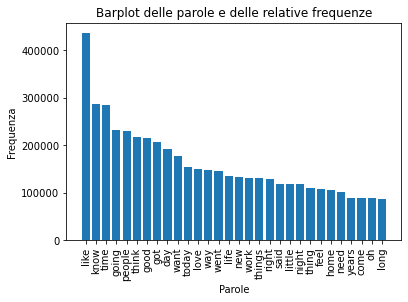

In [216]:
plt.bar(list(most_common_w.keys())[:30], list(most_common_w.values())[:30])
plt.xlabel("Parole")
plt.ylabel("Frequenza")
plt.title("Barplot delle parole e delle relative frequenze")
plt.xticks(rotation='vertical')
plt.show()

In [217]:
words_to_remove_1 = ['oh', 'ok', 'pm', 'th', ' e ', ' p ']
words_to_remove_2 = list(most_common_w.keys())[:30]

words_to_remove = words_to_remove_1 + words_to_remove_2

# Delete other words
def delete_other_words(text):
    words = [word for word in text.split() if word.lower() in words_to_remove]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
train['post'] = train['post'].apply(delete_other_words)

### Least common words

##### Ok!
We can declare the preprocessinh phase completed.
We can now compute the new length of the posts and have a look at the final result...

In [ ]:
train['new_length'] = train['post'].apply(post_length)

In [ ]:
train.head()

##### We save this dataset in a pickle object

In [6]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [213]:

# sample usage
save_object(train, 'train_clean_no_spain.pkl')

From now on, we will read this pickle object instead of running the whole code again

In [5]:
train = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/train_clean_2.pkl')
train = train[['post', 'age', 'gender']]
train

,post,age,gender
0,new,16,female
1,today today little like,14,male
2,want got want thing want got way good little l...,24,female
3,,24,male
4,love know today time want know life little yea...,23,female
...,...,...,...
526807,,34,male
526808,,24,female
526809,home think know like night home right want,13,male
526810,went night like people night,17,female


# PER SUSANNA: spostare/ eliminare questa seconda parte di EDA

In [ ]:
# How the length differs between males and females
fig = px.histogram(train[train.length <= 1000], x="length", color="gender")
fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
# Diversa lunghezza prima e dopo il pre-processing

fig = go.Figure()
fig.add_trace(go.Histogram(x=list(train[train.length < 1000].length)))
fig.add_trace(go.Histogram(x=list(train[train.length < 1000].new_length)))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# Embedding using Sentence Transformers

Our main source of inspiration:
https://www.youtube.com/watch?v=c7AqnswslWo

In [ ]:
# Tokenizer

# Pipeline that is tipically used:
# -   Remove punctuation                       (done)
# -   Remove stopwords                         (done)
# -   Implement lemmatization and tokenization (TODO)

# In our particular case, it seems that we have to do the following:
# -   Lemmatize each row
# -   Embed using sentence transformers

# At the present stage, it should be easy to do.
# So, first thing first, we need to tokenize and lemmatize every sentence we have. 
# After this opearation, we should have the same exact structure of the dataset, but this time the posts will be a little bit different because of the lemmatization.

### Lemmatization

In [100]:
# https://spacy.io/models/en

nlp = spacy.load("en_core_web_sm")

# Let's create or tokenizer function

def lemmatizer(sentence):
    doc = nlp(sentence)

    # Lemmatize:
    mytokens = [word.lemma_.strip() for word in doc]

    # Re-join
    sentence = " ".join(mytokens)

    # Return the sentence
    return(sentence)

##### Per prima cosa, facciamo la lemmatization (su tutte le 500k righe...)

In [106]:
# Let's see if this works:
train['lemmatize'] = train['post'].apply(lemmatizer)
train

,post,age,gender,length,lemmatize
0,ooh shiny new commenting,16,female,4,ooh shiny new commenting
1,today parade suked bad band year battle today ...,14,male,48,today parade suke bad band year battle today k...
2,know aabout anymore concerned everyday want bo...,24,female,80,know aabout anymore concerned everyday want bo...
3,roof sunset posted paul,24,male,7,roof sunset post paul
4,god love nanny absolutely greatest woman earth...,23,female,730,god love nanny absolutely great woman earth kn...
...,...,...,...,...,...
526807,write injuries sand kindnesses marble french p...,34,male,16,write injury sand kindness marble french prove...
526808,wes dad stan,24,female,7,wes dad stan
526809,prefer calling nice guy fact obviously carried...,13,male,152,prefer call nice guy fact obviously carry away...
526810,angela went othello night great noah shaved he...,17,female,77,angela go othello night great noah shave head ...


In [91]:
train.iloc[50].post

'blogger morning hope remember things wanted link seen dallas police department web site load story says department posting pictures alleged johns convicted trouble presumption guilt picture goes web site taint jury trouble dpd turns people pictures guilty story slate offering corrections myths aabout reagan reagan great communicator owed success mainly facility television public relations reagan uniter divider reagan incorrigible optimist reagan restored faith government presidency reagan tough policy soviet union brought aabout end cold war finally john kerry decried media consolidation'

In [109]:
# Lo salviamo in un oggetto a parte
save_object(train, 'lemmatization_2.pkl')

# C'è la spunta verde? Allora chiudi il mac

### Embedding using sentence transformers

In [3]:
lemmatization = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/lemmatization_2.pkl')
#mini_train = lemmatization[:100000]

lemmatization.shape

(503900, 5)

In [ ]:
# pip install -U sentence-transformers -q

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2') 

# https://www.sbert.net/docs/pretrained_models.html
# According to this official website, this model (all-MiniLM-L6-v2) "is 5 times faster and still offers good quality"

In [4]:
# model.encode('Hello world')
mini_train = lemmatization[:100000]

mini_train['embedding'] = mini_train['lemmatize'].apply(model.encode)
mini_train.head()

# 10000 righe --> 6m 19s
# proiezione 426k righe: 4h e mezza

,post,age,gender,length,lemmatize,embedding
0,ooh shiny new commenting,16,female,4,ooh shiny new commenting,"[-0.18770814, -0.13998552, 0.019073976, 0.0225..."
1,today parade suked bad band year battle today ...,14,male,48,today parade suke bad band year battle today k...,"[-0.11394925, 0.02999169, 0.014715457, -0.0732..."
2,know aabout anymore concerned everyday want bo...,24,female,80,know aabout anymore concerned everyday want bo...,"[-0.10992989, -0.04249898, 0.019761039, 0.0499..."
3,roof sunset posted paul,24,male,7,roof sunset post paul,"[-0.046943568, 0.13227944, 0.02199171, 0.00461..."
4,god love nanny absolutely greatest woman earth...,23,female,730,god love nanny absolutely great woman earth kn...,"[-0.03844242, -0.08146381, 0.017230963, 0.0577..."


In [7]:
save_object(mini_train, 'embedding_100k_prova2.pkl')

# Sono tante righe...

In [ ]:
embedding = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/embedding_100k.pkl')

# Idea: e se facessimo l'embedding pezzo per pezzo?

In pratica, per fare 500k righe ci metteremmo circa 6 ore... troppo.
Ma se facessimo un pezzo alla volta? 100k righe a pranzo, 100k righe a cena ecc ecc... 
Risparmieremmo tempo ed risorse

In [7]:
# Mini_train1: Sample di 500 righe
mini_train1 = train[['post']][:500]

# Lemmatization
mini_train1['lemmatize'] = mini_train1['post'].apply(lemmatizer)

# Embedding
mini_train1['embedding'] = mini_train1['lemmatize'].apply(model.encode)


In [8]:
# Mini_train2: Sample di 1000 righe
mini_train2 = train[['post']][:1000]

# Lemmatization
mini_train2['lemmatize'] = mini_train2['post'].apply(lemmatizer)

# Embedding
mini_train2['embedding'] = mini_train2['lemmatize'].apply(model.encode)

In [11]:
# A questo punto li confronto: le prime 500 righe di mini_train2 corrispondono in tutto e per tutto a mini_train1?

mini_train3 = mini_train1.embedding - mini_train2.embedding
mini_train3[:500]

# Sì! Uguale in tutto e per tutto
# Cioò significa che potremo runnare pezzo per pezzo, senza tenerci il computer impegnato per 10 ore di fila

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
495    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
496    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
497    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
498    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
499    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: embedding, Length: 500, dtype: object